In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import json
import time
import itertools
from scipy import stats
import psycopg2 as psql
from psycopg2.extras import RealDictCursor

import sys
sys.path.append("..")
from tools.flight_projection import *

import seaborn as sns
sns.set(color_codes=True)

try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

/home/victor/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:


def crop_ddr2_flight(fl):
    crd_start = [cd for cd in zip(fl['lat'],fl['lon']) if not any(math.isnan(n) for n in cd)][0]
    crd_end = [cd for cd in zip(fl['lat'],fl['lon']) if not any(math.isnan(n) for n in cd)][-1]
    
    dst_start = []
    dst_end = []
    
    for c in zip(fl['lat_seg_b'],fl['lon_seg_b'],fl['seq']):
        dst_start.append(calc_coord_dst((c[0],c[1]),crd_start))
        dst_end.append(calc_coord_dst((c[0],c[1]),crd_end))
    
    start_ix = np.argmin(dst_start)
    end_ix = np.argmin(dst_end)
    
    if start_ix != 1:
        start_ix = start_ix - 2
    if end_ix != len(fl['lat_seg_b'])+2:
        end_ix = end_ix + 2
        
    print('Start ix: %d, end ix: %d' % (start_ix,end_ix))
    
    for k in ['ep_seg_b','lat_seg_b','lon_seg_b','fl_seg_b','fl_seg_e','seq']:
        fl[k] = fl[k][start_ix:end_ix]
        
    if start_ix >= end_ix:
        print('Start index larger than end index')
        return None
        
    return fl


def add_waypoints(b):
    dc = {k: b[k] for k in ['ep_seg_b','lat_seg_b', 'lon_seg_b']}
    ac = {k: b[k] for k in ['ts','lat','lon','spd','hdg']}
    
    dc = pd.DataFrame.from_dict(dc)
    ac = pd.DataFrame.from_dict(ac)

    dc['wps'] = list(zip(dc.lat_seg_b, dc.lon_seg_b))
    try:
        df = add_waypoints_seq(ac, dc['wps'])
    except Exception as e:
        print(e)

    df[['curr_lat', 'curr_lon']] = df['curr_wp'].apply(pd.Series)
    df[['next_lat', 'next_lon']] = df['next_wp'].apply(pd.Series)
    df[['last_lat', 'last_lon']] = df['last_wp'].apply(pd.Series)
    
    return df


def realign_conflict(b):
    
    cfl_dst = 9260
    
    if len(b['lon_1']) != len(b['lon_2']):
        print('Flights not the same length')
        return None
    
    for i in range(1,len(b)):
        
        if calc_coord_dst_simple((b['lon_1'][-i],b['lat_1'][-i]),(b['lon_2'][-i],b['lat_2'][-i])) >= cfl_dst:
            for k in ['ts_1','lat_1','lon_1','alt_1','spd_1','hdg_1','roc_1',
                      'ts_2','lat_2','lon_2','alt_2','spd_2','hdg_2','roc_2']:
                b[k] = b[k][:-(i-1)]
            return (b)
    
    return None
        

def time_to_conflict(tr1,tr2):
    
    cfl_dst = 9260
    
    for i in range(len(tr1)):
        cdst = calc_coord_dst_simple((tr1['proj_lat'].iloc[i],
                                  tr1['proj_lon'].iloc[i]),
                                 (tr2['proj_lat'].iloc[i],
                                  tr2['proj_lon'].iloc[i])) 
        print(cdst)
        if cdst <= cfl_dst:
            ttc = tr1['ts'].iloc[i] - tr1['ts'].iloc[0]
            
            return ttc
    
    return None


def ttc_est(lat_1, lon_1, lat_2, lon_2, hdg_1, hdg_2, spd_1, spd_2):
    
    knots_to_ms = 0.514444
    ipz_lim = 9260 #meters
    m_per_deglat = 111200
    m_per_deglon = 68460
    
    alpha_1 = heading_diff(calc_compass_bearing((lat_1, lon_1),(lat_2, lon_2)), hdg_1)
    alpha_2 = heading_diff(calc_compass_bearing((lat_2, lon_2),(lat_1, lon_1)), hdg_2)
    
    gamma = 180 - (alpha_1 + alpha_2)
    
    if gamma < 0:
        return np.nan
    else:
        dy_1 = math.cos(math.radians(heading_diff(hdg_1,0))) * spd_1 * knots_to_ms
        dy_2 = math.cos(math.radians(heading_diff(hdg_2,0))) * spd_2 * knots_to_ms
        dx_1 = math.sin(math.radians(heading_diff(hdg_1,0))) * spd_1 * knots_to_ms
        dx_2 = math.sin(math.radians(heading_diff(hdg_2,0))) * spd_2 * knots_to_ms
        
        dx = abs(dx_1 - dx_2)
        dy = abs(dy_1 - dy_2)
        
        s = calc_coord_dst((lat_1, lon_1),(lat_2, lon_2))
        ttc = (s - ipz_lim) / np.sqrt((dy**2 + dx**2))
        
        return ttc

Start ix: 18, end ix: 29
Start ix: 19, end ix: 27


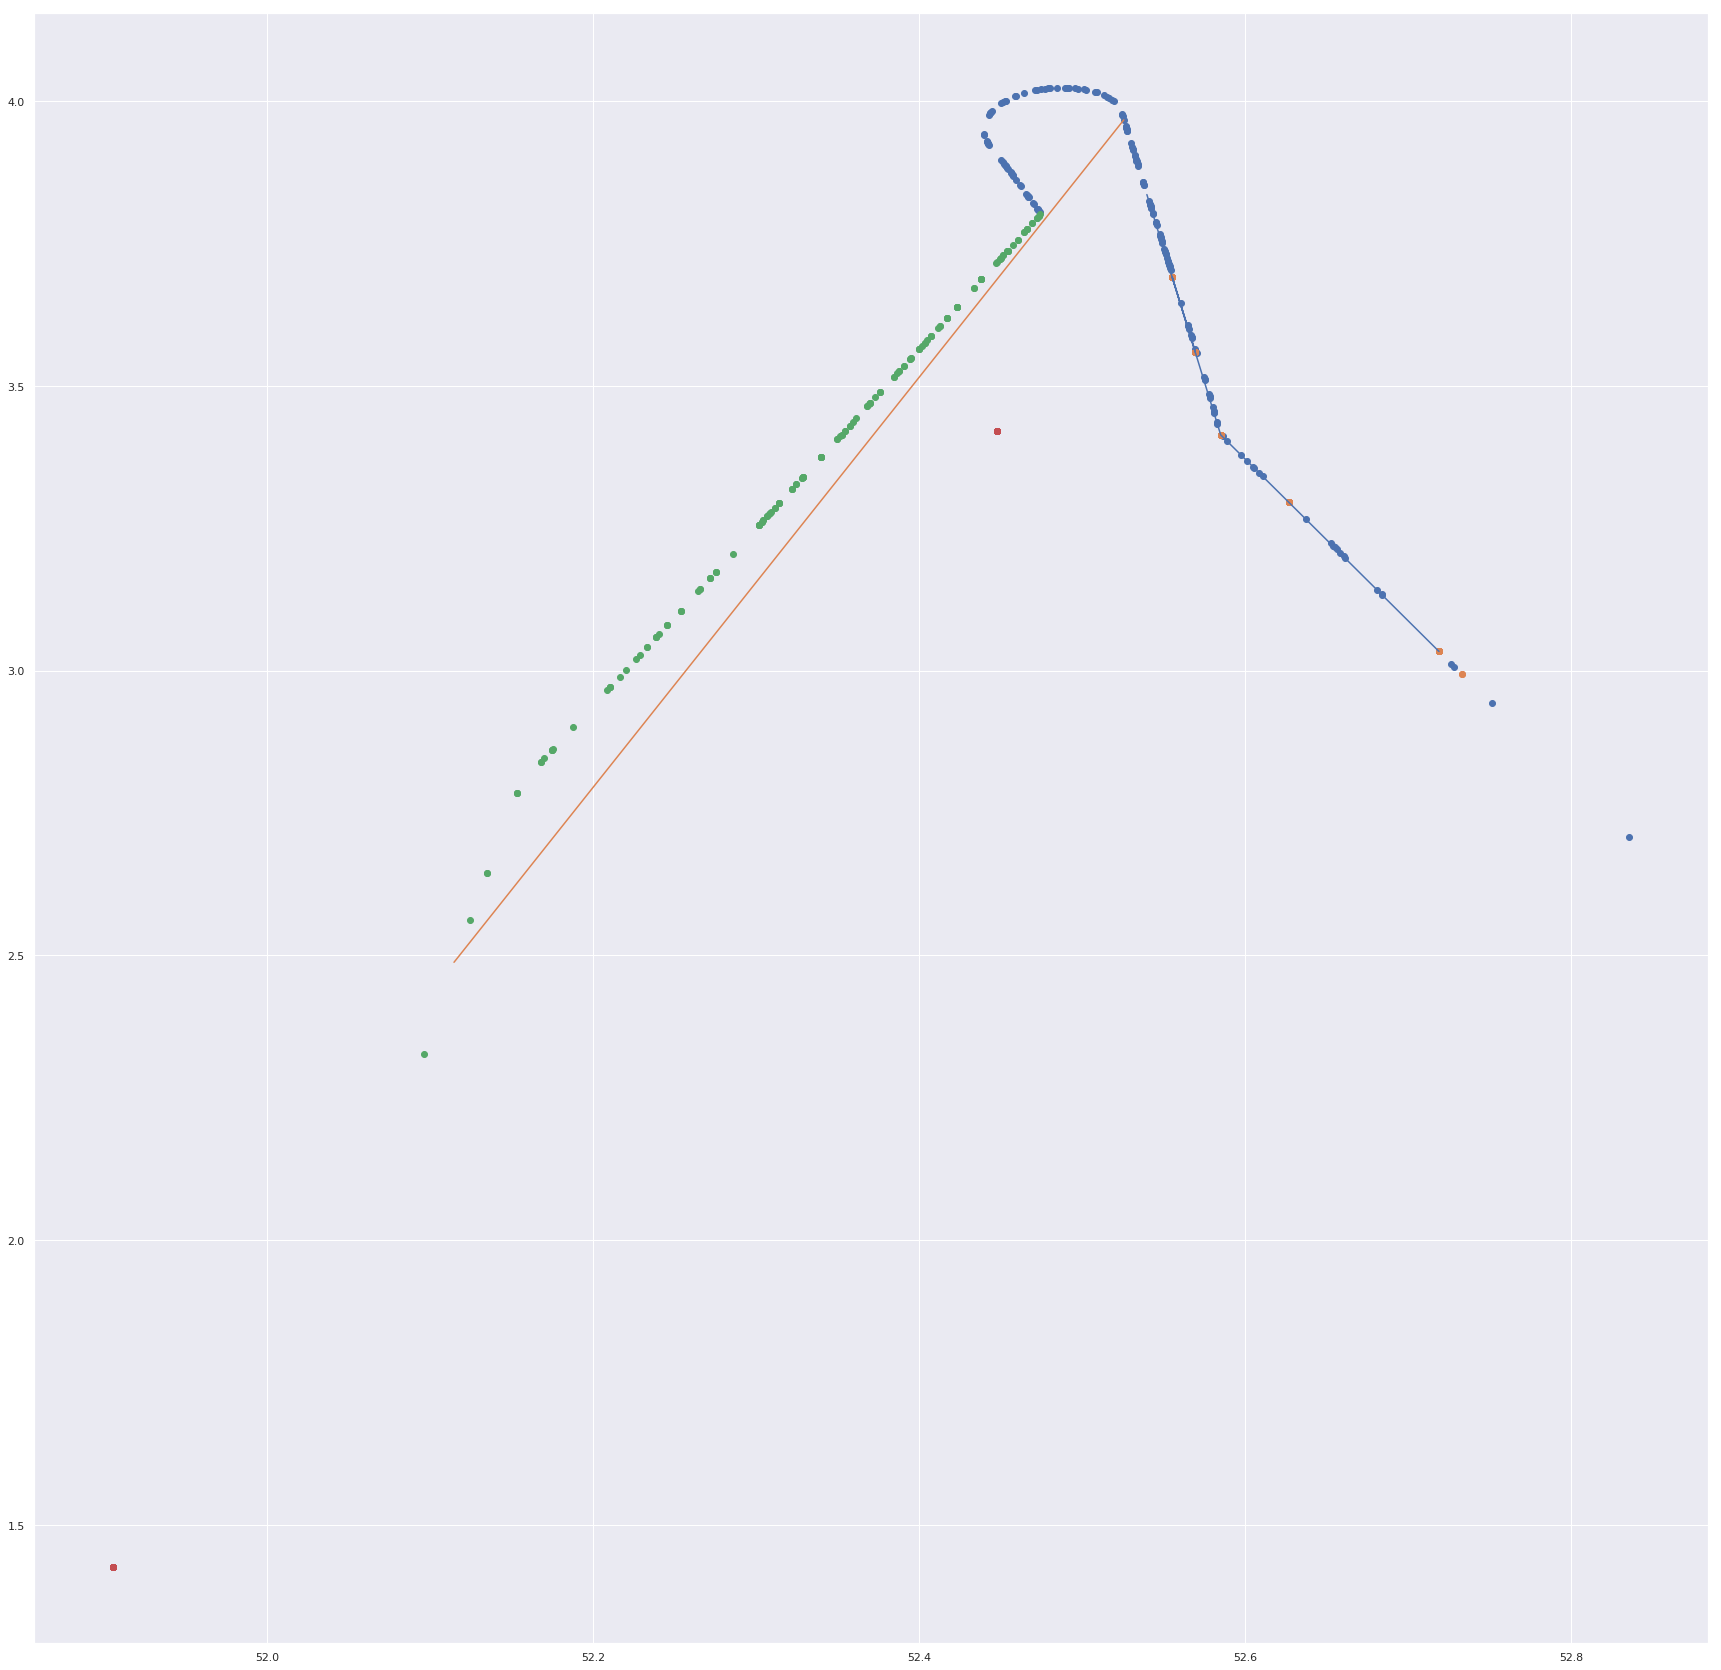

Start ix: 14, end ix: 23
Start ix: 7, end ix: 15


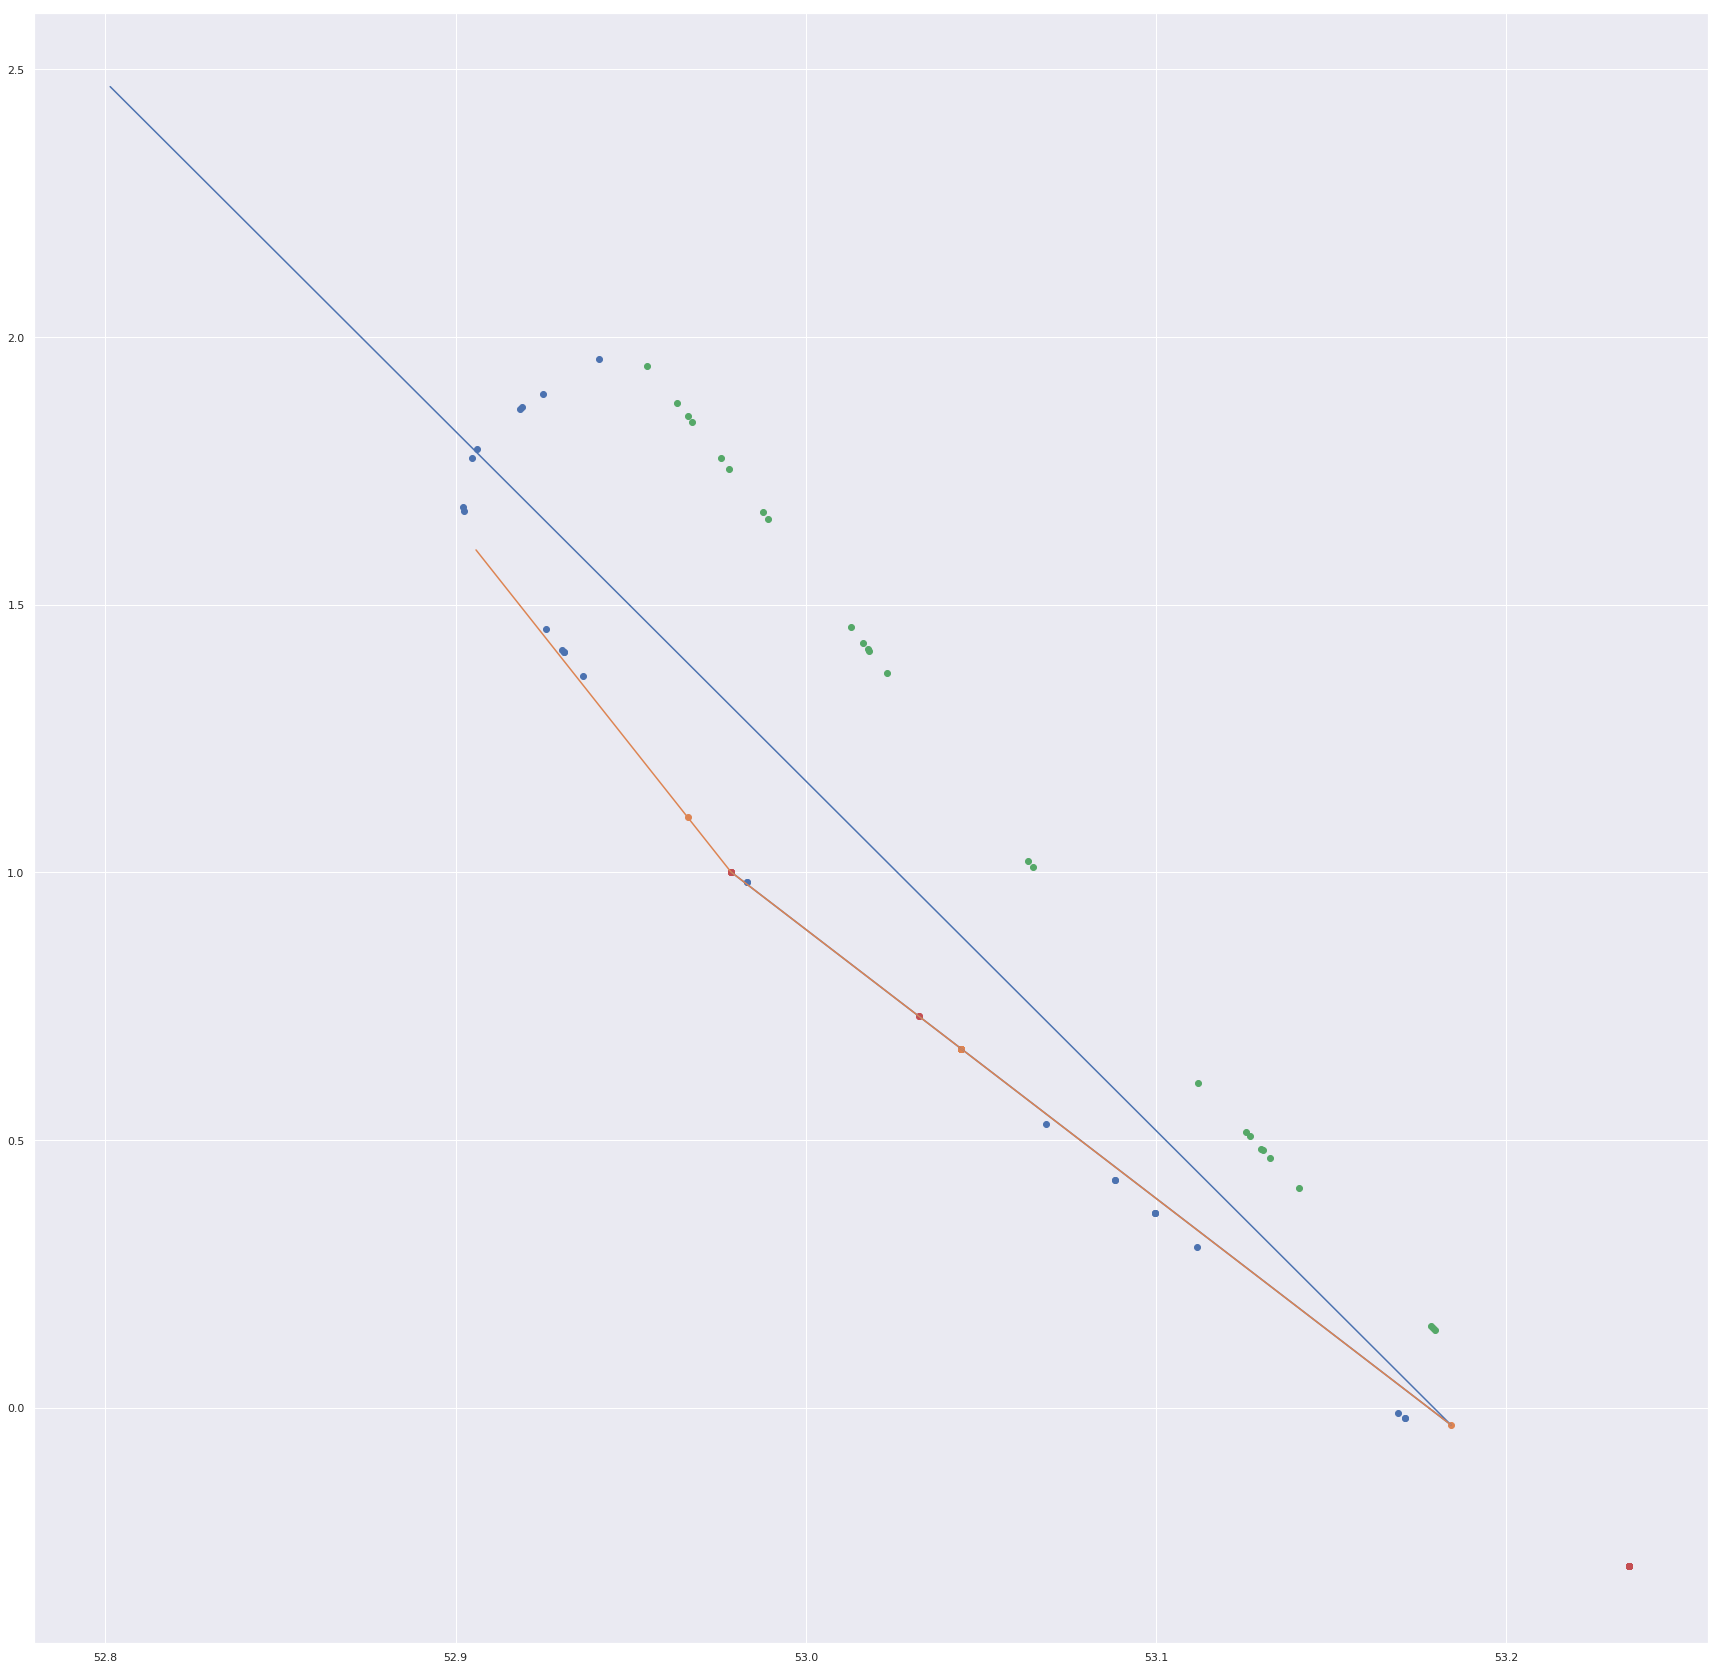

Start ix: 13, end ix: 27
Start ix: 14, end ix: 24


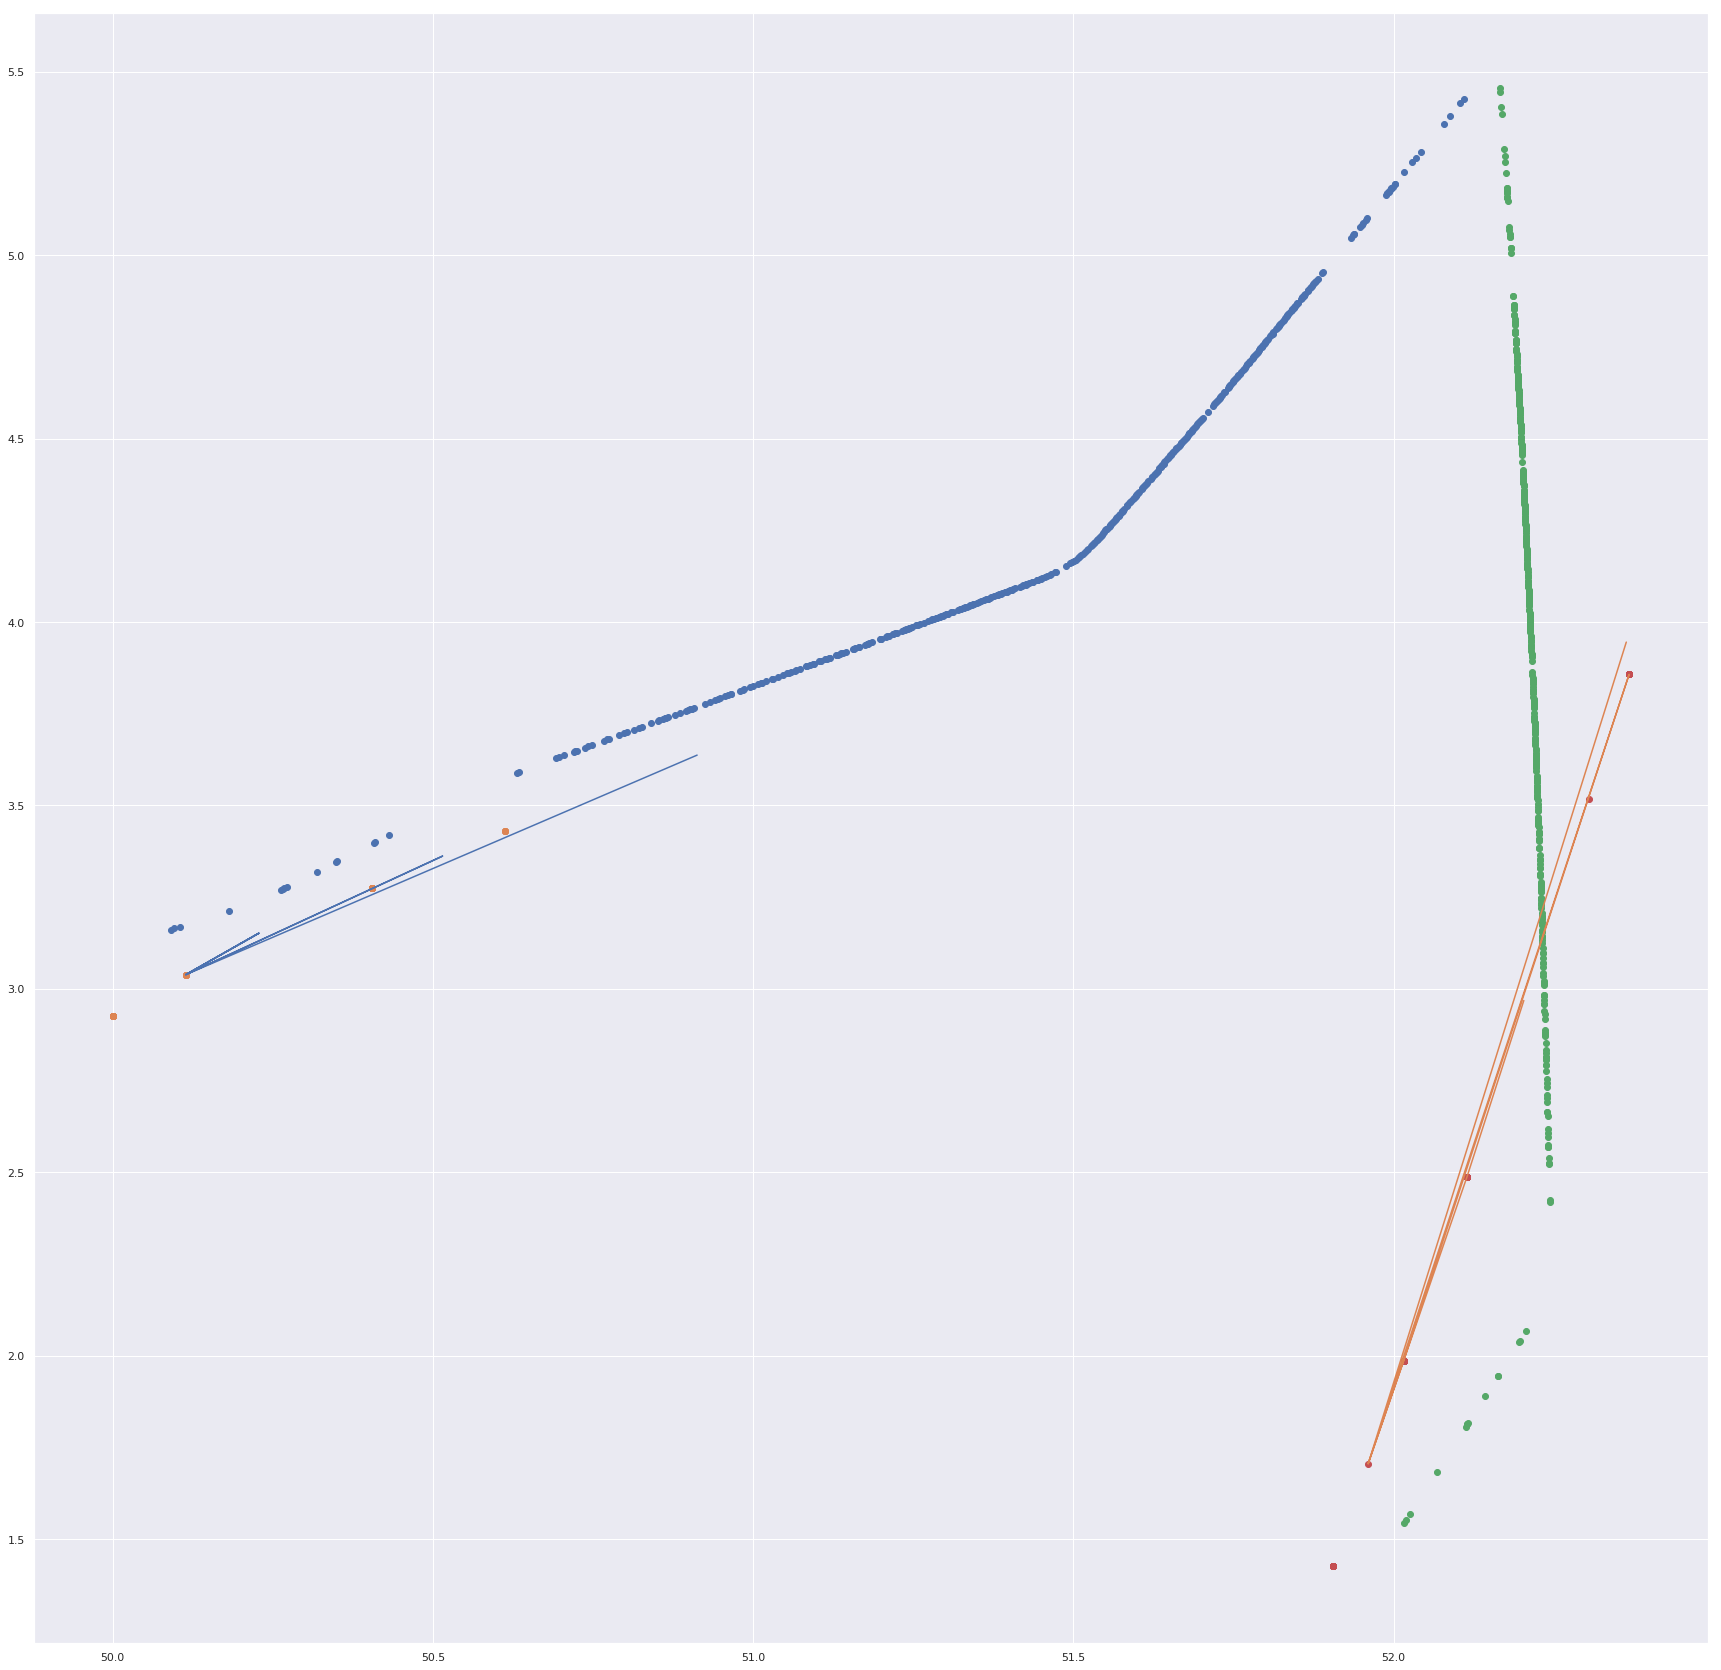

Start ix: 9, end ix: 17
Start ix: 25, end ix: 38


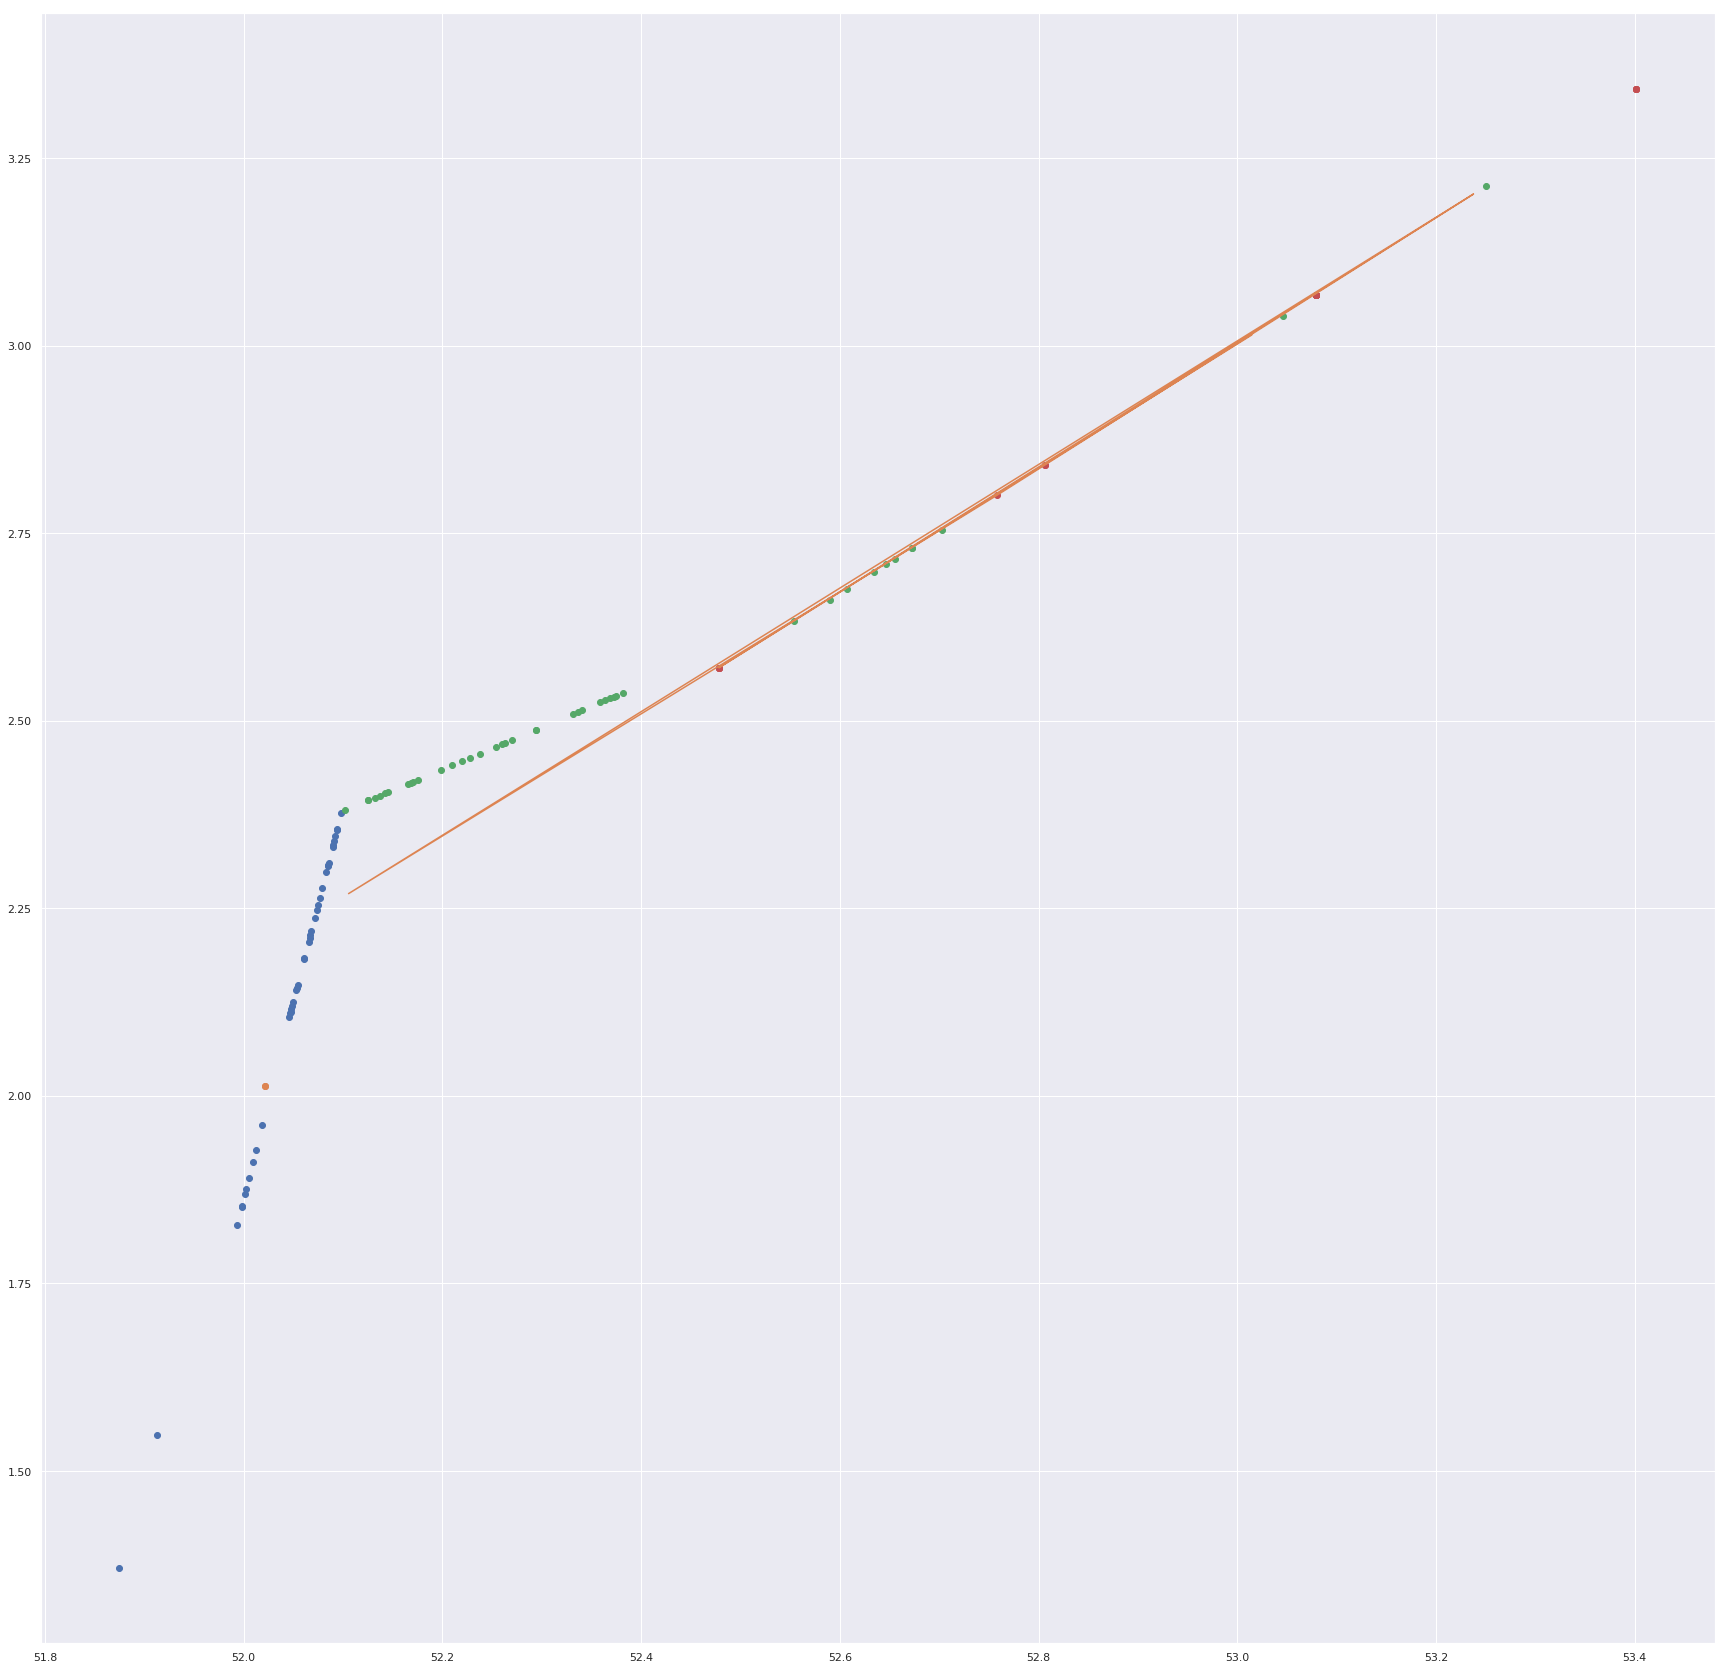

Start ix: 24, end ix: 32
Start ix: 5, end ix: 13


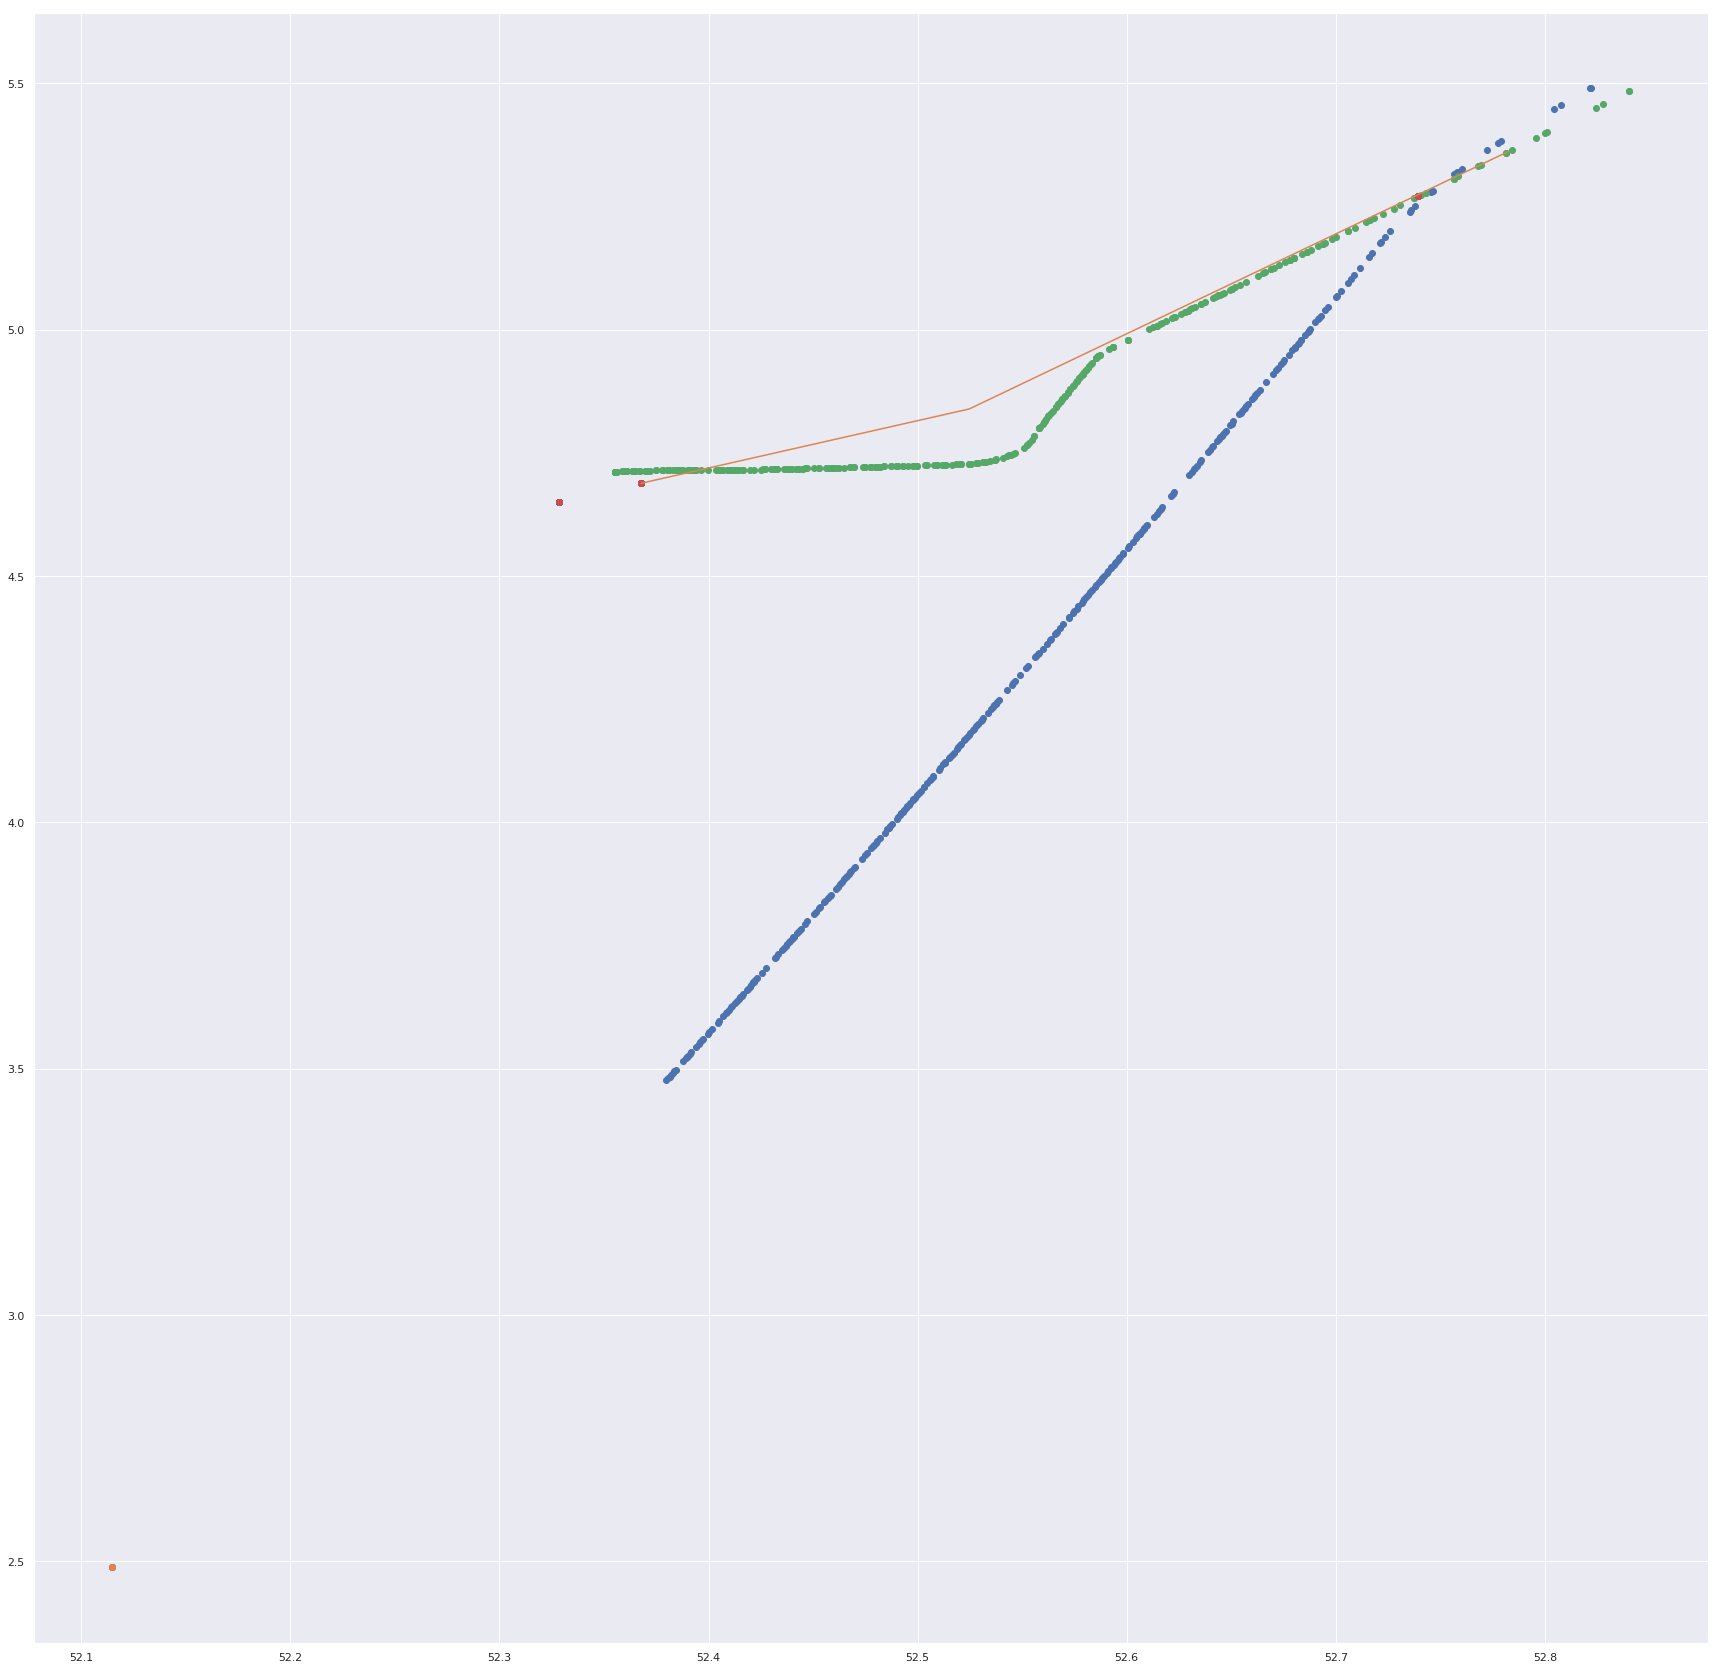

Start ix: 24, end ix: 32
Start ix: 5, end ix: 13


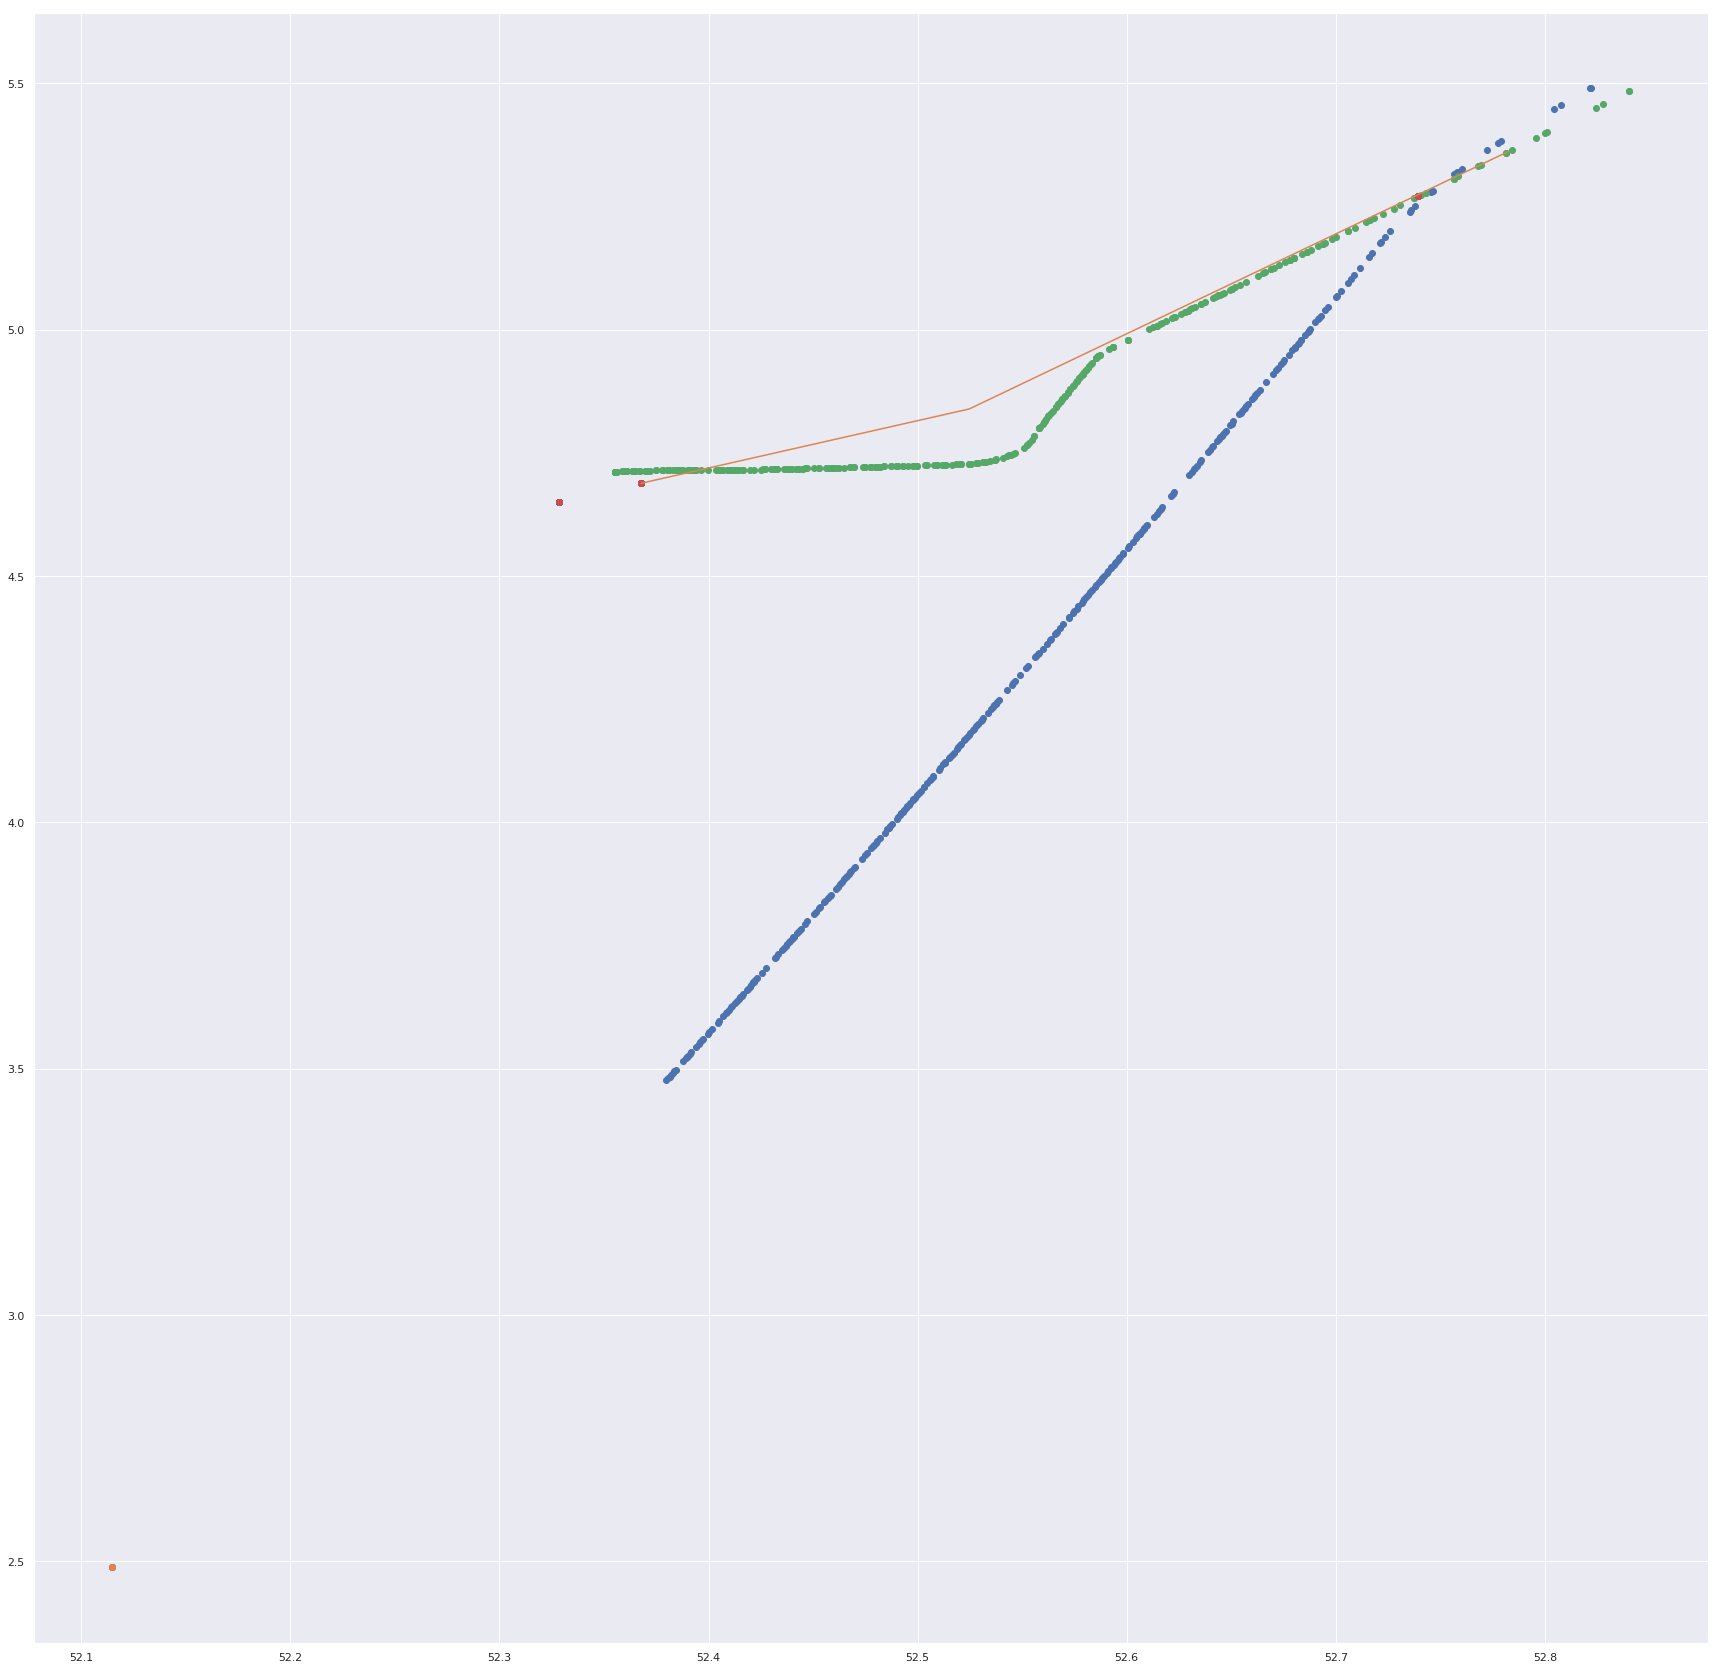

Start ix: 11, end ix: 22
Start ix: 22, end ix: 33


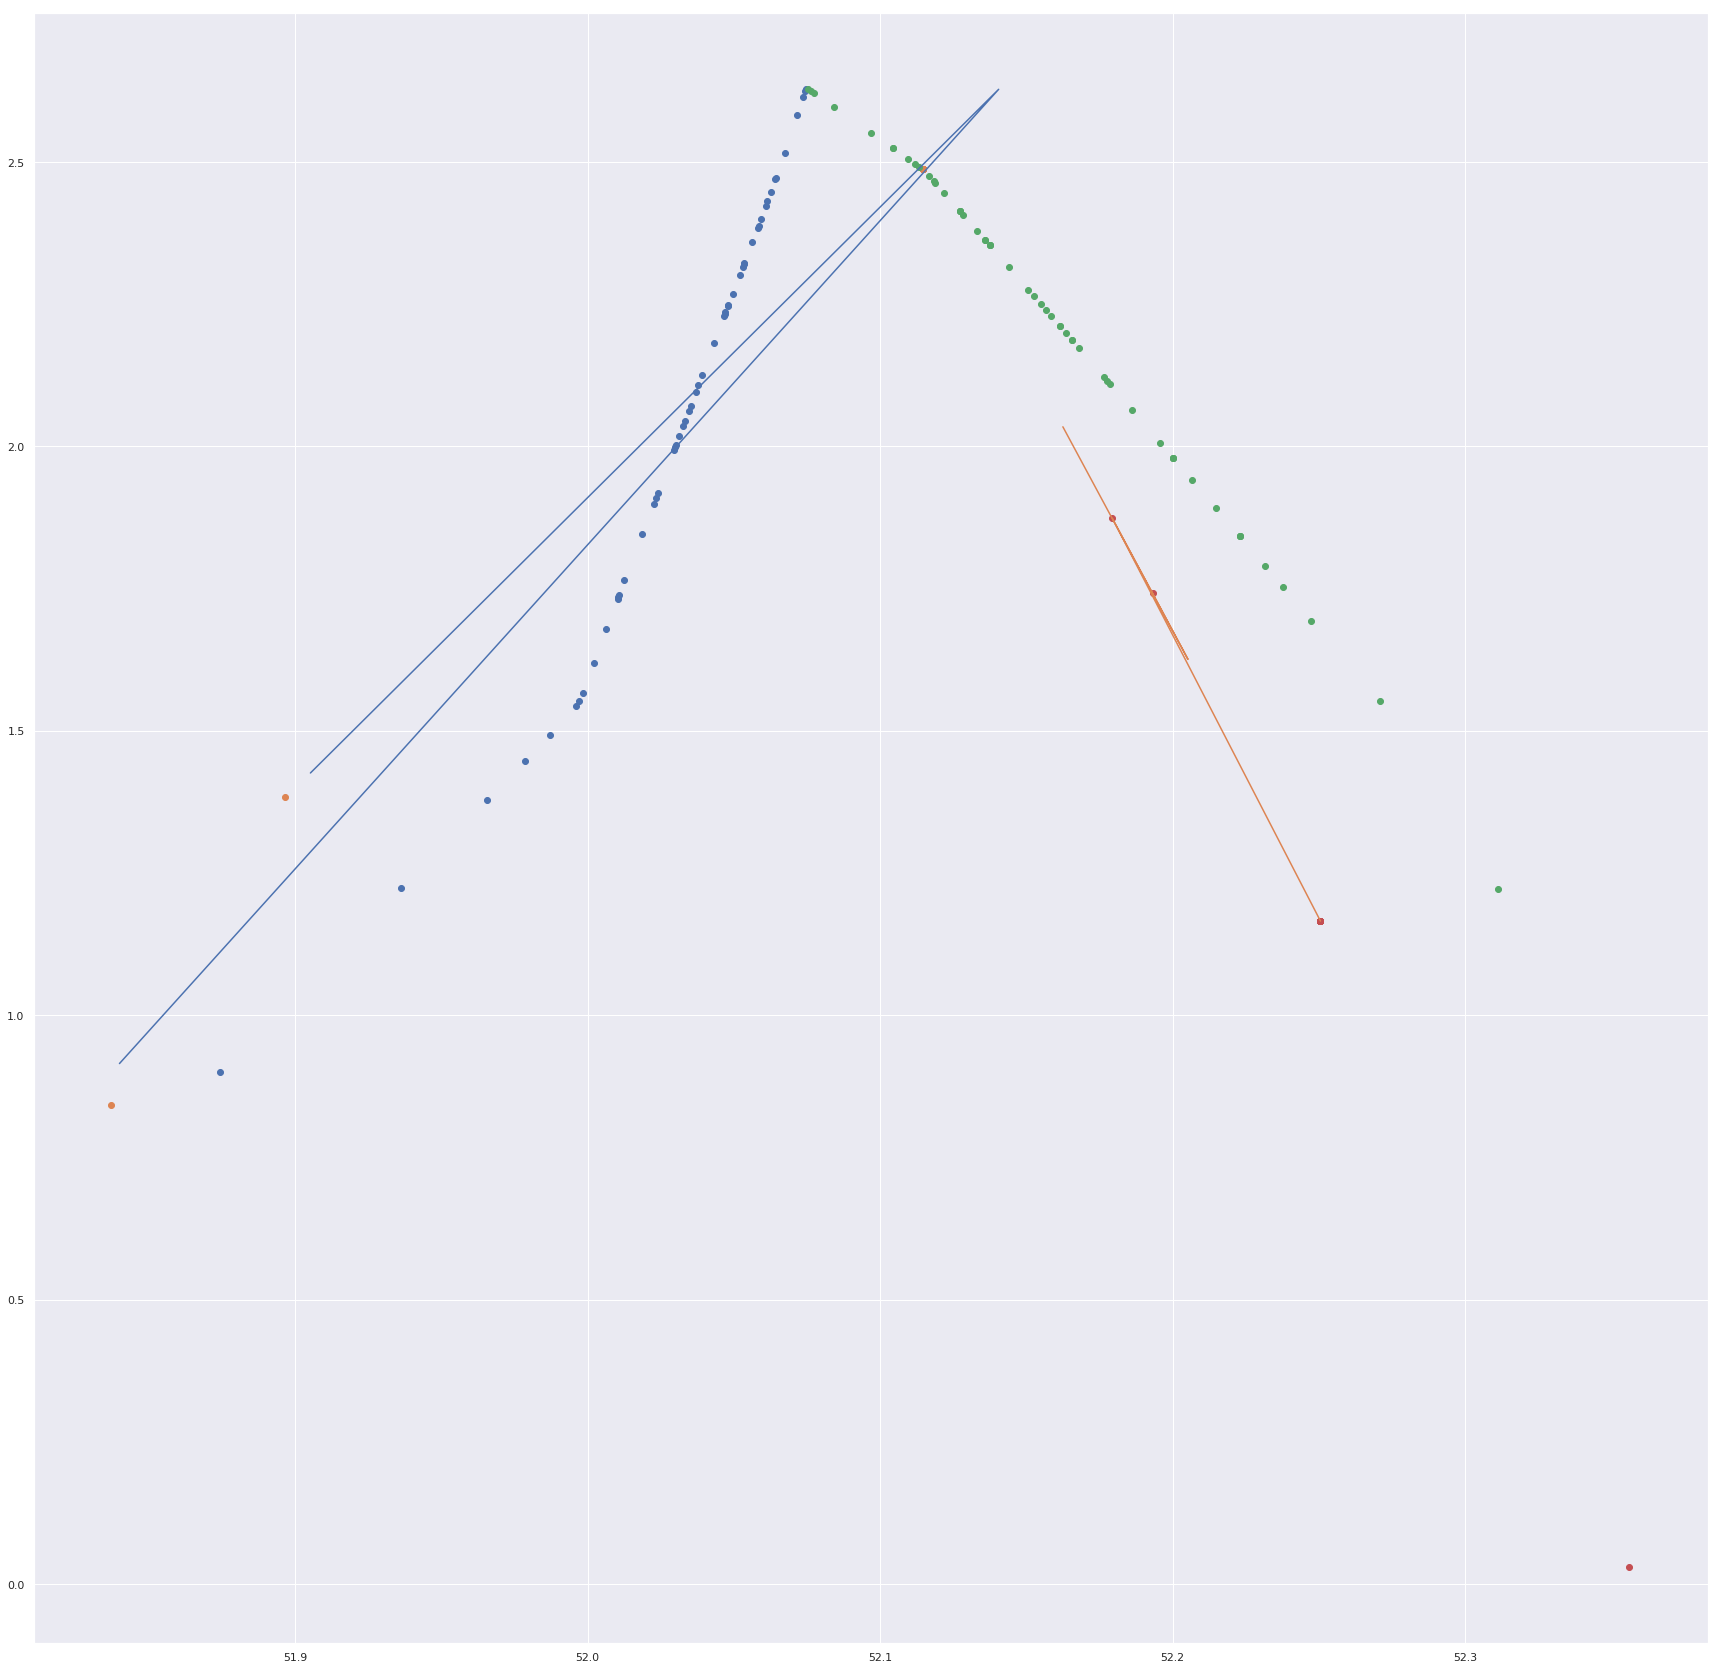

Start ix: 12, end ix: 26
Start ix: 21, end ix: 30


ValueError: Columns must be same length as key

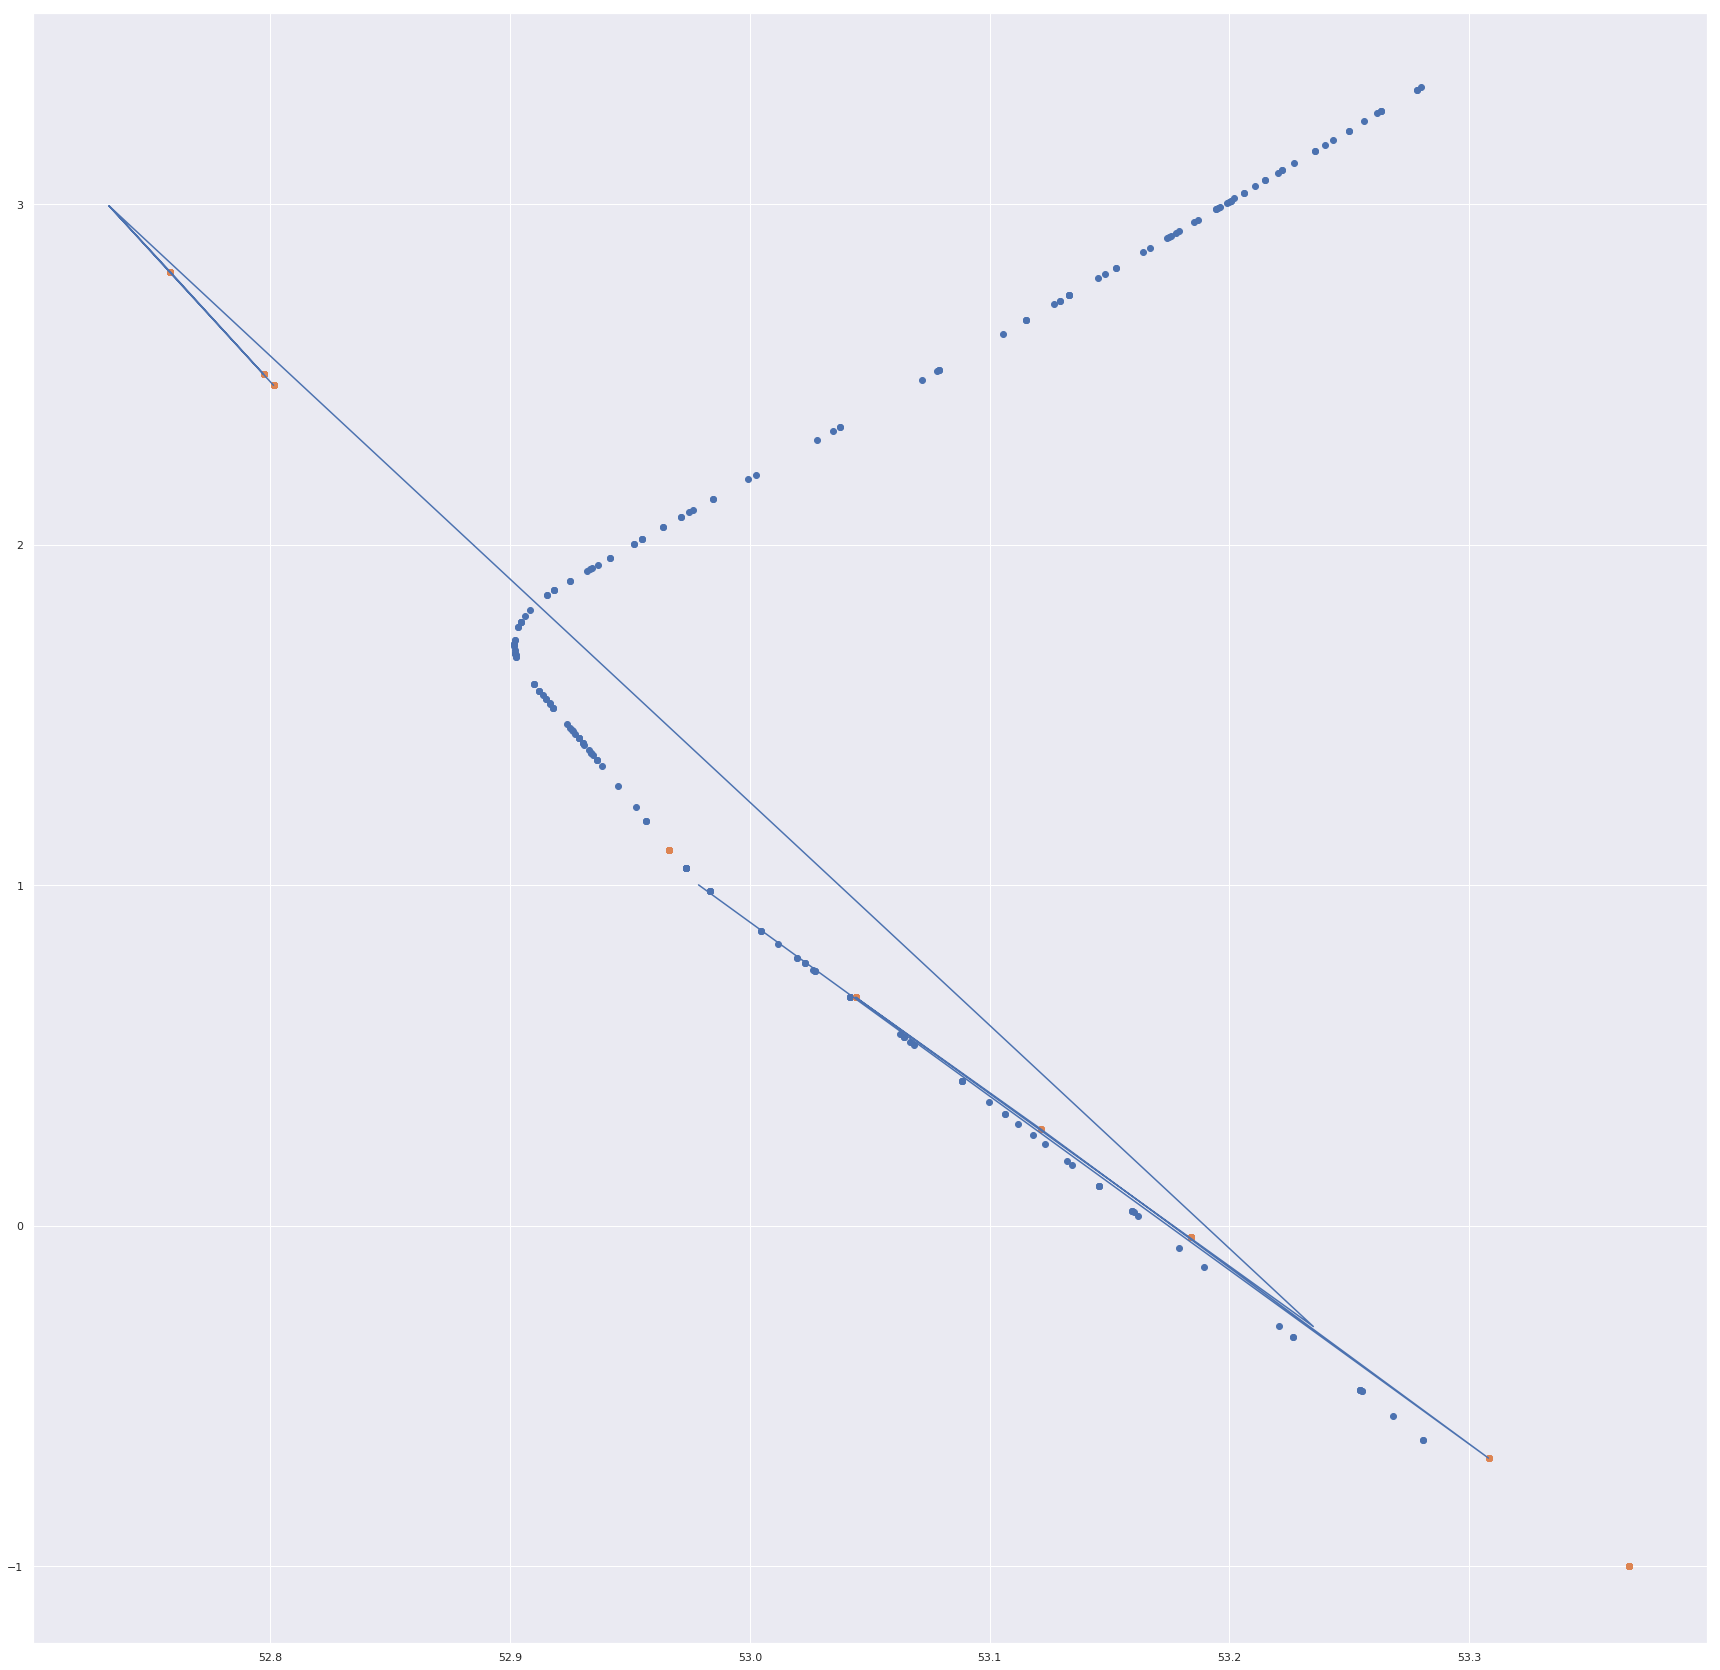

In [26]:
cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT * FROM public.ddr2_conflicts limit 10;")
batch = cur_read.fetchall()


for b in batch:
    
    fl_keys = ['ts', 'lat','lon','hdg','alt','spd','roc','ep_seg_b','lat_seg_b','lon_seg_b','fl_seg_b','fl_seg_e','seq']
    
    plt.figure(figsize=(30,30))
    
    for kx in ['_1','_2']:
        bn = {}
        for k in fl_keys:
            bn[k] = b["%s%s" % (k,kx)]

        bn = crop_ddr2_flight(bn)
        bnn = add_waypoints(bn)

        plt.scatter(bnn['lat'],bnn['lon'])
        plt.scatter(bnn['curr_lat'],bnn['curr_lon'])
        plt.plot(bnn['next_lat'],bnn['next_lon'])

    plt.show()

Start ix: 19, end ix: 27
Start ix: 37, end ix: 44
Start ix: 2, end ix: 15
Start ix: 37, end ix: 45
Start ix: 0, end ix: 10
Start ix: 27, end ix: 35
Start ix: 13, end ix: 27
Start ix: 27, end ix: 46
Start ix: 9, end ix: 17
Start ix: 55, end ix: 82
Start ix: 9, end ix: 20
Start ix: 83, end ix: 90
Start ix: 8, end ix: 19
Start ix: 46, end ix: 66
Start ix: 9, end ix: 25
Start ix: 28, end ix: 46
Start ix: 12, end ix: 20
Start ix: 1, end ix: 26
Start ix: 11, end ix: 21
Start ix: 46, end ix: 54
Start ix: 24, end ix: 33
Start ix: 43, end ix: 51
Start ix: 12, end ix: 23
Start ix: 18, end ix: 24
Start ix: 12, end ix: 26
Start ix: 44, end ix: 53
Start ix: 8, end ix: 21
Start ix: 48, end ix: 54
Start ix: 12, end ix: 23
Start ix: 26, end ix: 34
Start ix: 12, end ix: 23
Start ix: 18, end ix: 24
Start ix: 1, end ix: 12
Start ix: 41, end ix: 60
Start ix: 14, end ix: 22
Start ix: 17, end ix: 28
Start ix: 13, end ix: 25
Start ix: 55, end ix: 62
Start ix: 0, end ix: 13
Start ix: 56, end ix: 62
Start ix: 

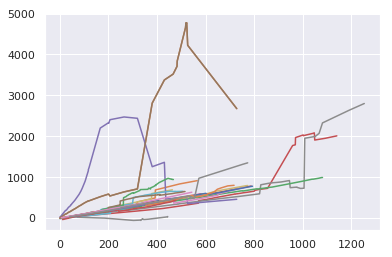

In [3]:
cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT * FROM public.ddr2_conflicts;")
batch = cur_read.fetchall()

from mpl_toolkits.mplot3d import Axes3D

dim='2d'
la_time = 1200
bin_sec = 20
bin_dp_df = {}
spd_lim = 30000

cfl_dst = 9260
for b in batch:

    try:
        b = realign_conflict(b)
    except Exception as e:
        print('Error in realigning Conflict')
        b = None
        
    if b:
        fl_keys = ['ts', 'lat','lon','hdg','alt','spd','roc','ep_seg_b',
                   'lat_seg_b','lon_seg_b','fl_seg_b','fl_seg_e','seq']
        
        b['ettc'] = []
        b['ttc'] = []
        b['ecpa'] = []

        try:
            fl1 = {}
            for k in fl_keys:
                fl1[k] = b["%s%s" % (k,'_1')]
            fl1 = crop_ddr2_flight(fl1)
            fl1 = add_waypoints(fl1)
            fl1['hdg_int'] = fl1.apply(lambda x: calc_compass_bearing(x['curr_wp'],x['next_wp']), axis=1)

            fl2 = {}
            for k in fl_keys:
                fl2[k] = b["%s%s" % (k,'_2')]
            fl2 = crop_ddr2_flight(fl2)
            fl2 = add_waypoints(fl2)
            fl2['hdg_int'] = fl2.apply(lambda x: calc_compass_bearing(x['curr_wp'],x['next_wp']), axis=1)
        except Exception as e:
            print('Preprocessing data failed')
            print(e)
        
        try:
            for t in range(len(b['ts_1'])):

                    b['ttc'].append(b['ts_1'][-1] - b['ts_1'][t])
                    b['ettc'].append(ttc_est(fl1['lat'][t], fl1['lon'][t], fl2['lat'][t], fl2['lon'][t], 
                                         fl1['hdg_int'][t], fl2['hdg_int'][t], fl1['spd'][t], fl2['spd'][t]))
            b['ttc_diff'] = [x-y for x,y in zip(b['ttc'],b['ettc'])]
        except:
            continue

        for tt in range(int(la_time/bin_sec)):
            bmin = tt*bin_sec
            bmax = (tt+1)*bin_sec
            if str(bmax) not in list(bin_dp_df.keys()):
                bin_dp_df[str(bmax)] = []
                
            bin_dp_df[str(bmax)].extend([e for e,t in zip(b['ttc_diff'], b['ttc']) 
                                                if t >= bmin and t <= bmax])


        plt.plot(b['ttc'], b['ettc'])
plt.show()

In [1]:
box_data = []

bin_df = bin_dp_df

for k in [kx for kx in bin_df.keys() if int(kx) <= 600]:
    box_data.append((int(k), [i for i in bin_df[k] if not np.isnan(i)]))
    
box_data_sort = sorted(box_data, key=lambda tup: tup[0])
box_data_2 = [i[1] for i in box_data_sort]

x = range(len(box_data_2))

plt.figure(figsize=(20,8))
plt.boxplot(box_data_2, showfliers=False, patch_artist=True, whis=[5,95])
plt.xticks(x, [i[0] for i in box_data_sort])
plt.xticks(rotation=70)
plt.xlabel('Look-ahead time (seconds)')
plt.ylabel('TTC difference in seconds')
plt.title('Evolution of TTC error over look-ahead time')
plt.show()
        

NameError: name 'bin_dp_df' is not defined